# PCA Plots of bioRxiv

This notebook is designed to run PCA over the document embeddings and plot various components against each other. The goal here is to understand the concepts best captured by each PC.

In [1]:
%load_ext autoreload
%autoreload 2
import sys

import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

from annorxiver_modules.pca_plot_helper import (
    display_clouds,
    generate_scatter_plots,
    plot_scatter_clouds,
)

In [2]:
# Set up porting from python to R
# and R to python :mindblown:

import rpy2.rinterface

%load_ext rpy2.ipython

In [3]:
journal_map_df = pd.read_csv(
    "../exploratory_data_analysis/output/biorxiv_article_metadata.tsv", sep="\t"
)
journal_map_df.head()

author_type      heading               category       document  \
0  regular article  new results               genetics  440735_v1.xml   
1  regular article  new results        systems biology  775270_v1.xml   
2  regular article  new results               genetics  242404_v1.xml   
3  regular article  new results           neuroscience  872994_v1.xml   
4  regular article  new results  developmental biology  080853_v2.xml   

                         doi  
0             10.1101/440735  
1             10.1101/775270  
2             10.1101/242404  
3  10.1101/2019.12.11.872994  
4             10.1101/080853

# PCA the Documents

Run PCA over the documents. Generates 50 principal components, but can generate more or less.

In [4]:
n_components = 50
random_state = 100

In [5]:
biorxiv_articles_df = pd.read_csv(
    "../word_vector_experiment/output/word2vec_output/biorxiv_all_articles_300_fixed.tsv.xz",
    sep="\t",
)
biorxiv_articles_df = biorxiv_articles_df.dropna()
biorxiv_articles_df.head()

document    feat_0    feat_1    feat_2    feat_3    feat_4    feat_5  \
0  440735_v1.xml  0.063813  0.012187 -0.156229 -0.158987  0.165480 -0.346612   
1  775270_v1.xml -0.201064  0.011870 -0.354809 -0.150633  0.095305 -0.507254   
2  242404_v1.xml -0.204741 -0.107589 -0.062853  0.140793  0.066307 -0.463290   
3  872994_v1.xml -0.256990 -0.055972 -0.300816  0.495731  0.290070 -0.310817   
4  080853_v2.xml  0.167641  0.046808 -0.709753  0.232242 -0.139213 -0.319284   

     feat_6    feat_7    feat_8  ...  feat_290  feat_291  feat_292  feat_293  \
0  0.001741 -0.107139  0.684055  ... -0.140772 -0.143405 -0.081427 -0.248220   
1 -0.339986  0.303313  0.944561  ... -0.115199 -0.259798  0.272955 -0.346138   
2 -0.106492 -0.040269  0.557687  ... -0.229839 -0.325765 -0.064586 -0.300529   
3 -0.481578 -0.161373  0.483896  ...  0.148916 -0.217426  0.195183 -0.069086   
4 -0.314807  0.310180  0.317704  ...  0.540693  0.264286  0.256323  0.137184   

   feat_294  feat_295  feat_296  feat_297  feat_298  feat_299  
0 -0.771470 -0.235455  0.547801  0.859663 -0.063151  0.012667  
1 -0.844158 -0.596267  0.121678  0.959160 -0.747369 -0.073314  
2 -0.707948 -0.479390  0.381809  0.968333 -0.402499 -0.109250  
3 -0.545689 -0.517949  0.265230  0.645038 -0.843499 -0.142928  
4 -0.754344 -0.145583  0.032544  0.507430 -0.374320  0.473060  

[5 rows x 301 columns]

In [6]:
reducer = PCA(n_components=n_components, random_state=random_state)

embedding = reducer.fit_transform(
    biorxiv_articles_df[[f"feat_{idx}" for idx in range(300)]].values
)

pca_df = (
    pd.DataFrame(
        embedding, columns=[f"pca{dim}" for dim in range(1, n_components + 1, 1)]
    )
    .assign(document=biorxiv_articles_df.document.values.tolist())
    .merge(journal_map_df[["category", "document", "doi"]], on="document")
)

latest_version = (
    pca_df.groupby("doi", as_index=False)
    .agg({"document": "last"})
    .document.values.tolist()
)

pca_df = pca_df.query(f"document in {latest_version}").reset_index(drop=True)

pca_df.head()

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0  2.053579  0.184550  1.422882  0.514214  0.827999  1.481143  1.349989   
1  3.028835  1.533814  1.033410  0.240783 -0.495331 -1.069095  0.624508   
2  2.771886 -1.498743 -1.428488 -0.023041 -0.058196 -0.682447  0.164408   
3 -2.486485  0.194417  0.429193 -1.725880  0.148164  0.620072 -0.105085   
4  1.091883 -0.443026 -1.852581  0.276939  0.444201  0.620760  0.668932   

       pca8      pca9     pca10  ...     pca44     pca45     pca46     pca47  \
0 -0.504884  0.956632  0.526988  ...  0.155340 -0.207816 -0.229422 -0.219047   
1 -0.287174 -0.443155  0.623836  ... -0.107833 -0.192181  0.354452  0.132203   
2  0.298304 -0.010330  0.029617  ... -0.051154 -0.171084  0.083361 -0.070674   
3 -0.711720 -0.378533 -0.341593  ...  0.056524 -0.256185 -0.137200  0.064784   
4 -0.832606 -0.753092  0.065677  ... -0.045185  0.017576  0.059019  0.125921   

      pca48     pca49     pca50       document         category  \
0  0.015639  0.009587  0.069667  775270_v1.xml  systems biology   
1 -0.129546 -0.135735 -0.078943  242404_v1.xml         genetics   
2  0.067347 -0.028724  0.202792  872994_v1.xml     neuroscience   
3  0.166386 -0.033347 -0.014356  464958_v1.xml   cancer biology   
4 -0.050839 -0.083712 -0.138349  039735_v1.xml     biochemistry   

                         doi  
0             10.1101/775270  
1             10.1101/242404  
2  10.1101/2019.12.11.872994  
3             10.1101/464958  
4             10.1101/039735  

[5 rows x 53 columns]

In [7]:
reducer.explained_variance_

array([3.72428315, 2.09940896, 1.23131003, 1.00798319, 0.79391119,
       0.63722064, 0.57441816, 0.4094876 , 0.29548992, 0.23682071,
       0.2189394 , 0.16372958, 0.14399905, 0.13033514, 0.12012635,
       0.09790672, 0.09332534, 0.09000639, 0.08378458, 0.07738475,
       0.07135593, 0.06809858, 0.06516133, 0.06198795, 0.0600145 ,
       0.05894035, 0.05348792, 0.04924299, 0.04768241, 0.04590198,
       0.04411294, 0.04051674, 0.03923582, 0.03807215, 0.03560691,
       0.03451643, 0.03333076, 0.03260035, 0.03082265, 0.03020154,
       0.02922086, 0.02804269, 0.02658023, 0.02600218, 0.02524129,
       0.02482245, 0.02432323, 0.02306163, 0.02217745, 0.02138299])

In [8]:
reducer.explained_variance_ratio_

array([0.25202153, 0.1420666 , 0.08332251, 0.06821003, 0.05372382,
       0.0431206 , 0.03887077, 0.02770995, 0.01999575, 0.01602561,
       0.01481559, 0.01107955, 0.00974439, 0.00881975, 0.00812893,
       0.00662533, 0.00631531, 0.00609072, 0.00566969, 0.00523661,
       0.00482864, 0.00460822, 0.00440945, 0.00419471, 0.00406117,
       0.00398848, 0.00361952, 0.00333226, 0.00322666, 0.00310618,
       0.00298511, 0.00274176, 0.00265508, 0.00257633, 0.00240951,
       0.00233572, 0.00225549, 0.00220606, 0.00208576, 0.00204373,
       0.00197737, 0.00189764, 0.00179868, 0.00175956, 0.00170807,
       0.00167973, 0.00164595, 0.00156058, 0.00150074, 0.00144698])

In [9]:
(pca_df.category.sort_values().unique())

array(['animal behavior and cognition', 'biochemistry', 'bioengineering',
       'bioinformatics', 'biophysics', 'cancer biology', 'cell biology',
       'clinical trials', 'developmental biology', 'ecology',
       'epidemiology', 'evolutionary biology', 'genetics', 'genomics',
       'immunology', 'microbiology', 'molecular biology', 'neuroscience',
       'none', 'paleontology', 'pathology', 'pharmacology', 'physiology',
       'plant biology', 'scientific communication',
       'scientific communication and education', 'synthetic biology',
       'systems biology', 'zoology'], dtype=object)

# Plot the PCA axes

This section visualizes PCA axes and attempts to provide an explanation for each plotted PC.
Give there are 50 pcs generated this notebook/section will only focus on PCs that generate a clear enough signal.

## Basis PCs

When analyzing PCs, it is generally a good idea to start off with the PCs that are easily distinguishable and then branch out to PCs that are harder to interpret. This section focuses on PCs: 1,2,3,4 and 5.

These PCs correspond to the following concepts:

| PC | Concept (negative vs positive)|
| --- | --- |
| PCA1 | Quantitative Biology vs Molecular Biology |
| PCA2 | Neuroscience vs Genomics |
| PCA3 | Sequencing vs Disease |
| PCA4 | Microbiology vs Cell Biology |
| PCA5 | RNA-seq vs Evolutional Biology |

In [10]:
global_color_palette = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99"]

### PCA1 vs PCA2

In [11]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
)

These word clouds depict the following concepts: quantitative biology vs molecular biology (left) and genomics vs neuroscience (right). The cells below provide evidence for the previous claim

In [12]:
selected_categories = [
    "biochemistry",
    "bioinformatics",
    "cell biology",
    "neuroscience",
    "scientific communication",
]

In [13]:
pca_sample_df = (
    pca_df.query(f"category in {selected_categories}")
    .groupby("category")
    .apply(lambda x: x.sample(200, random_state=100) if len(x) > 200 else x)
    .reset_index(drop=True)
)
pca_sample_df.head()

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0 -2.608565 -0.186445  0.712581  1.237389  0.012092  0.512359  0.980404   
1 -1.912287 -0.940998 -1.921230 -0.009329  1.147037  0.083547 -1.166438   
2 -2.719035 -0.078353 -0.536074  0.158118  0.544794  0.829366  0.149812   
3 -1.790798 -0.064469 -1.539884  0.532367  0.407940  0.479334 -0.020517   
4 -0.840854  0.020569 -1.966897  0.441750  0.679229  0.714437 -0.402438   

       pca8      pca9     pca10  ...     pca44     pca45     pca46     pca47  \
0 -0.689188  0.136035 -0.366219  ... -0.058489  0.180459  0.251906  0.218062   
1 -1.224881 -0.671164  1.072988  ... -0.223456  0.116459 -0.070826  0.232038   
2 -0.767920 -0.541467  0.039423  ...  0.015255  0.292659 -0.005707 -0.003043   
3 -1.053748 -0.549132  0.991071  ...  0.182051 -0.240964 -0.126694 -0.037746   
4 -0.779678 -0.672447  0.692260  ... -0.123572 -0.206913 -0.351686  0.114175   

      pca48     pca49     pca50       document      category  \
0  0.286431  0.056095  0.133211  698951_v1.xml  biochemistry   
1  0.100003 -0.111317  0.132937  138891_v1.xml  biochemistry   
2 -0.094489 -0.170648 -0.276516  099440_v2.xml  biochemistry   
3 -0.070548  0.260945 -0.161380  876789_v1.xml  biochemistry   
4 -0.224573  0.166918 -0.008235  040907_v2.xml  biochemistry   

                         doi  
0             10.1101/698951  
1             10.1101/138891  
2             10.1101/099440  
3  10.1101/2019.12.15.876789  
4             10.1101/040907  

[5 rows x 53 columns]

This is mardown to preserve the code.
jupytext is terrible and handling magic cells.
This cell needs to be R so I can use cowplot effectivelyfunction:
https://github.com/has2k1/plotnine/issues/46

%%R -i pca_sample_df

library(ggplot2)

color_mapper <- c(
    'biochemistry' = '#a6cee3',
    'bioinformatics'= '#1f78b4',
    'cell biology'='#b2df8a',
    'neuroscience'='#33a02c',
    'scientific communication'='#fb9a99'
)

g <- (
        ggplot(pca_sample_df)
        + aes(x=pca1, y=pca2, color=factor(category))
        + theme_bw()
        + theme(
            legend.position="left",
            text=element_text(family = "Arial", size=16),
            rect=element_rect(color="black"),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank()
        )
        + geom_point()
        + scale_y_continuous(position="right")
        + scale_color_manual(values=color_mapper)
        + labs(
            x="PC1",
            y="PC2",
            color="Article Category",
            title="PCA of BioRxiv (Word Dim: 300)"
        )
)

Cairo::CairoSVG(
    file="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca02_reversed.svg",
    height=5,
    width=10,
)

print(g)

In [ ]:
generate_scatter_plots(
    pca_df,
    x="pca1",
    y="pca2",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca02.svg",
)

In [ ]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca02.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca01_v_pca02_figure.png",
)

Take note that pca2 clusters neruoscience papers on the negative axis while genomics papers are on the positive axis (up and down). PCA 1 places papers that are more focused on quantitative biology on the right and molecular biology to the left. Hence why bioinforamtics papers are shifted more to the right and cell biology papers are shifted more to the left. This plot visually confirms the above finding.

### PCA1 vs PCA 3

In [17]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_03_cossim_word_cloud.png",
)

These word clouds depict the following concepts: quantitative biology vs molecular biology (left) and disease vs sequencing (right)

In [18]:
selected_categories = [
    "bioinformatics",
    "epidemiology",
    "genetics",
    "paleontology",
    "pathology",
]

In [19]:
generate_scatter_plots(
    pca_df,
    x="pca1",
    y="pca3",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca03.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca01_v_pca03.svg


<ggplot: (-9223363297847431273)>


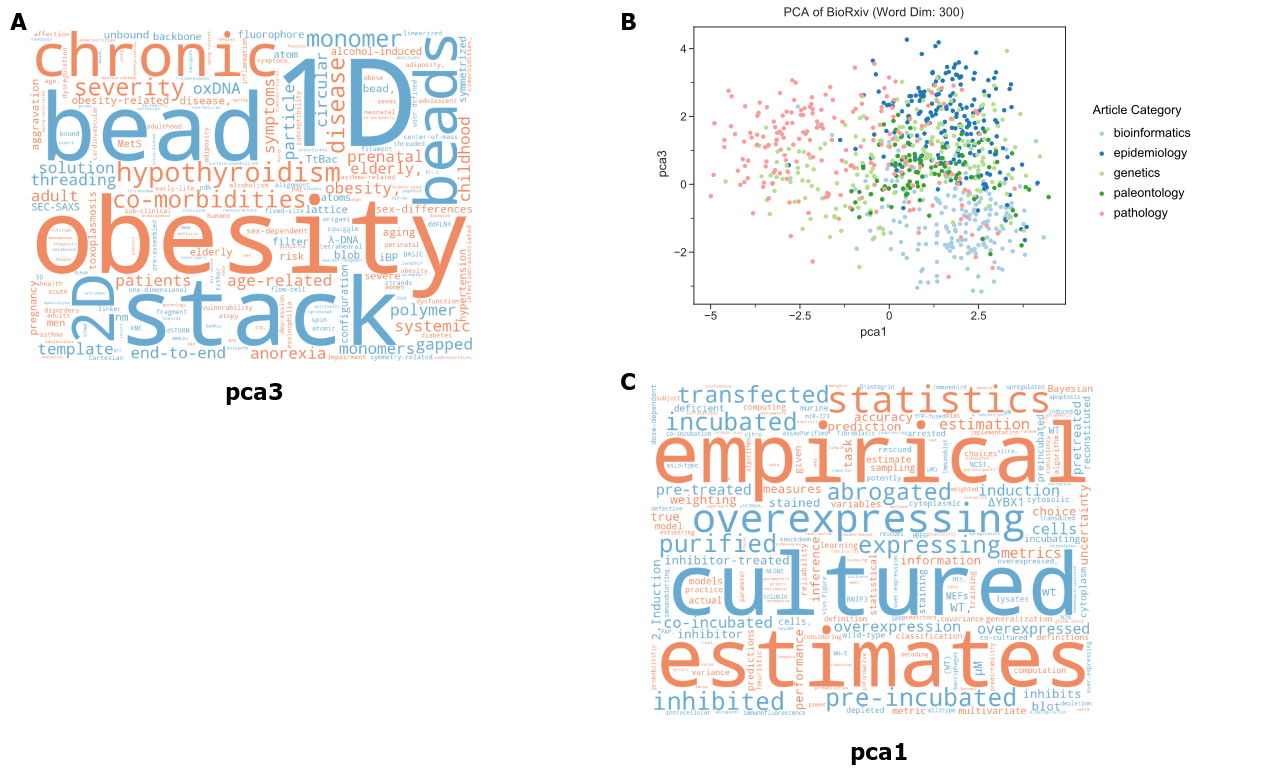

In [20]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca03.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_03_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca01_v_pca03_figure.png",
)

Take note that pca3 clusters sequencing based papers on the negative axis (down) while disease papers are on the positive axis (up). When plotted against PCA1 it looks like epidemiology papers dominate the top right quadrant, while bottom right quadrant contains bioinformatics papers. This makes sense as many bioinformatic papers consist of some sort of sequencing technologies, while epidemiology is focused on measuring disease and its progression. Both take quantitative views, which is why they are on the positive size of PCA1.

### PCA2 vs PCA3

In [21]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_03_cossim_word_cloud.png",
)

These word clouds depict the following concepts: neuroscience to genomics (left) and disease vs sequencing (right)

In [22]:
selected_categories = [
    "epidemiology",
    "genetics",
    "genomics",
    "neuroscience",
    "pathology",
]

In [23]:
generate_scatter_plots(
    pca_df,
    x="pca2",
    y="pca3",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca03.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca02_v_pca03.svg


<ggplot: (-9223363297847438297)>


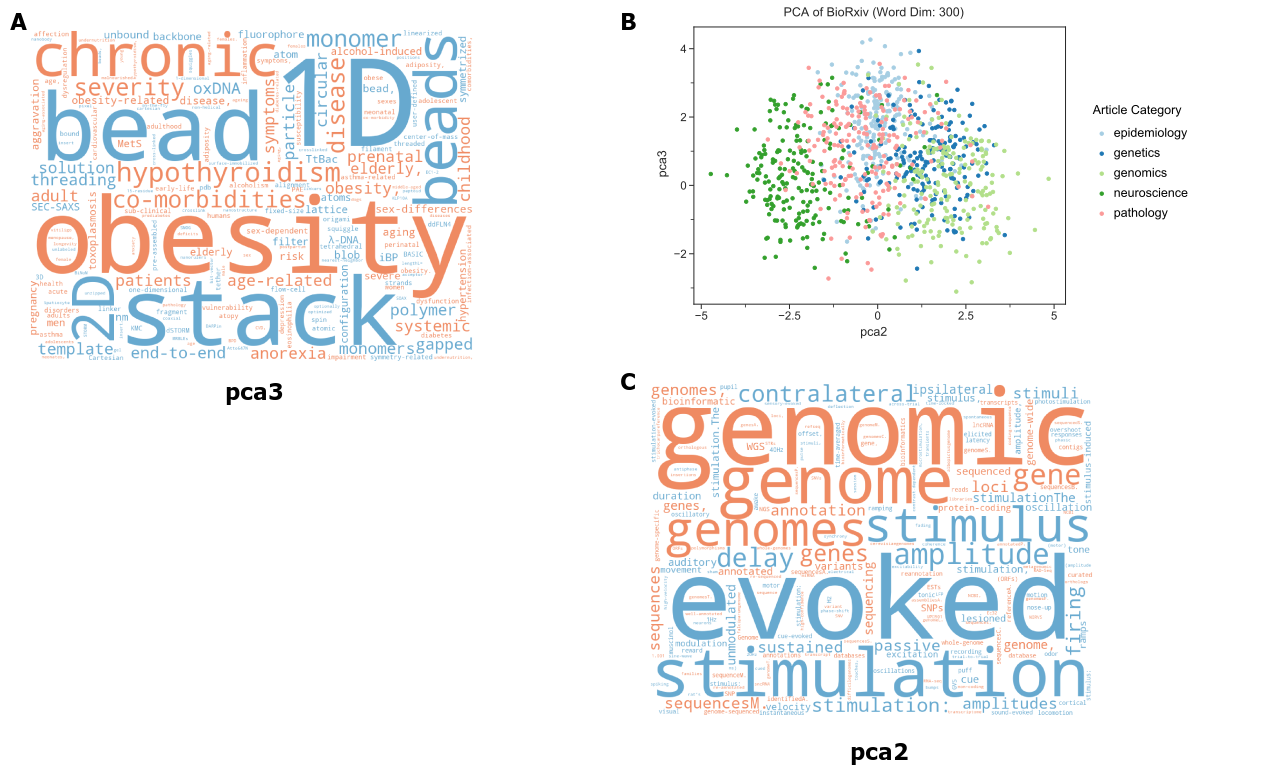

In [24]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca03.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_03_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca02_v_pca03_figure.png",
)

Note that bottom right quadrant comprises of mainly bioinformatics papers, which makes sense given that quadrant represents sequencing and genomics related papers (hence bioinformatics). The bottom left quadrant contains papers that have sequencing terms mentioned, but are more related to neuroscience than genomics (thats what forms the biophysics clusters). The top left are papers that relate to neuroscience and focused on disease while top right are genomics related papers that focus on disease.

### PCA3 vs PCA5

In [25]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_03_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_05_cossim_word_cloud.png",
)

These word clouds depict the following concepts: sequencing vs disease (left) and RNA-seq vs evolutionary biology (right)

In [26]:
selected_categories = [
    "bioinformatics",
    "ecology",
    "evolutionary biology",
    "epidemiology",
    "paleontology",
]

In [27]:
generate_scatter_plots(
    pca_df,
    x="pca3",
    y="pca5",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca03_v_pca05.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca03_v_pca05.svg


<ggplot: (-9223363297847078228)>


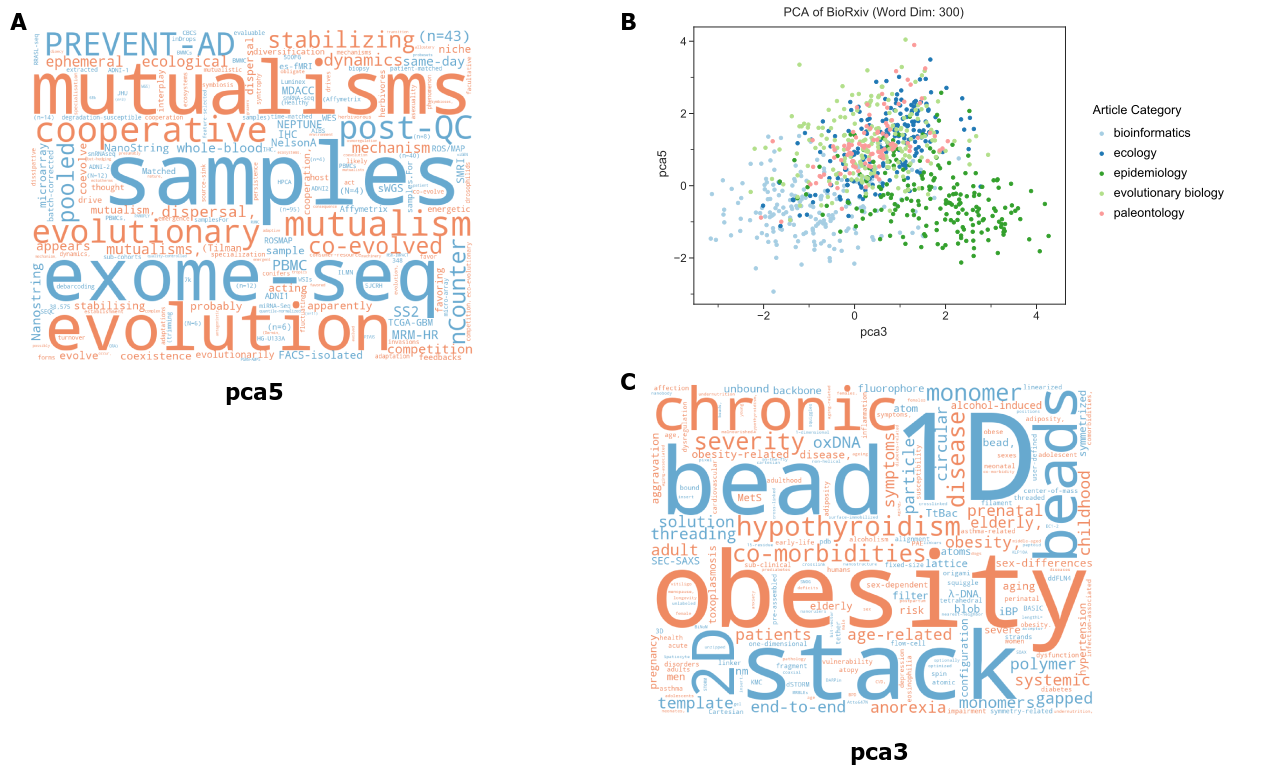

In [28]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca03_v_pca05.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_03_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_05_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca03_v_pca05_figure.png",
)

In [29]:
(
    pca_df[["pca3", "pca5", "category", "doi"]]
    .query("pca3 > 0 & pca5 > 0")
    .category.value_counts()
    .head(10)
)

evolutionary biology             2975
ecology                          2329
neuroscience                     1850
microbiology                     1421
genetics                         1111
genomics                         1058
plant biology                    1036
developmental biology             879
cell biology                      486
animal behavior and cognition     455
Name: category, dtype: int64

In [30]:
(
    pca_df[["pca3", "pca5", "category", "doi"]]
    .query("pca3 < 0 & pca5 < 0")
    .category.value_counts()
    .head(10)
)

bioinformatics       4287
neuroscience         3303
genomics             1603
microbiology         1399
cell biology          948
bioengineering        908
molecular biology     722
biophysics            663
biochemistry          591
genetics              585
Name: category, dtype: int64

Looking at the top-right quadrant and bottom-left quadrant, the top 10 categories provide evidence for the concepts mentioned above. Since PCA5 contains RNA-seq concepts on the negative sdes and PCA3 has sequencing as well on its negative axis, one would expect the top category for the bottom-left quadrant be bioinformatics related. Likewise the top right should be focused on evolutionary biology and possibly disease.

### PCA1 vs PCA4

In [31]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_04_cossim_word_cloud.png",
)

These word cloud produces the following concepts: qunatitative biology vs molecular biology (left) and microbiology vs cell biology (right).

In [32]:
selected_categories = [
    "cell biology",
    "epidemiology",
    "immunology",
    "microbiology",
    "systems biology",
]

In [33]:
generate_scatter_plots(
    pca_df,
    x="pca1",
    y="pca4",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca04.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca01_v_pca04.svg


<ggplot: (-9223363297870928303)>


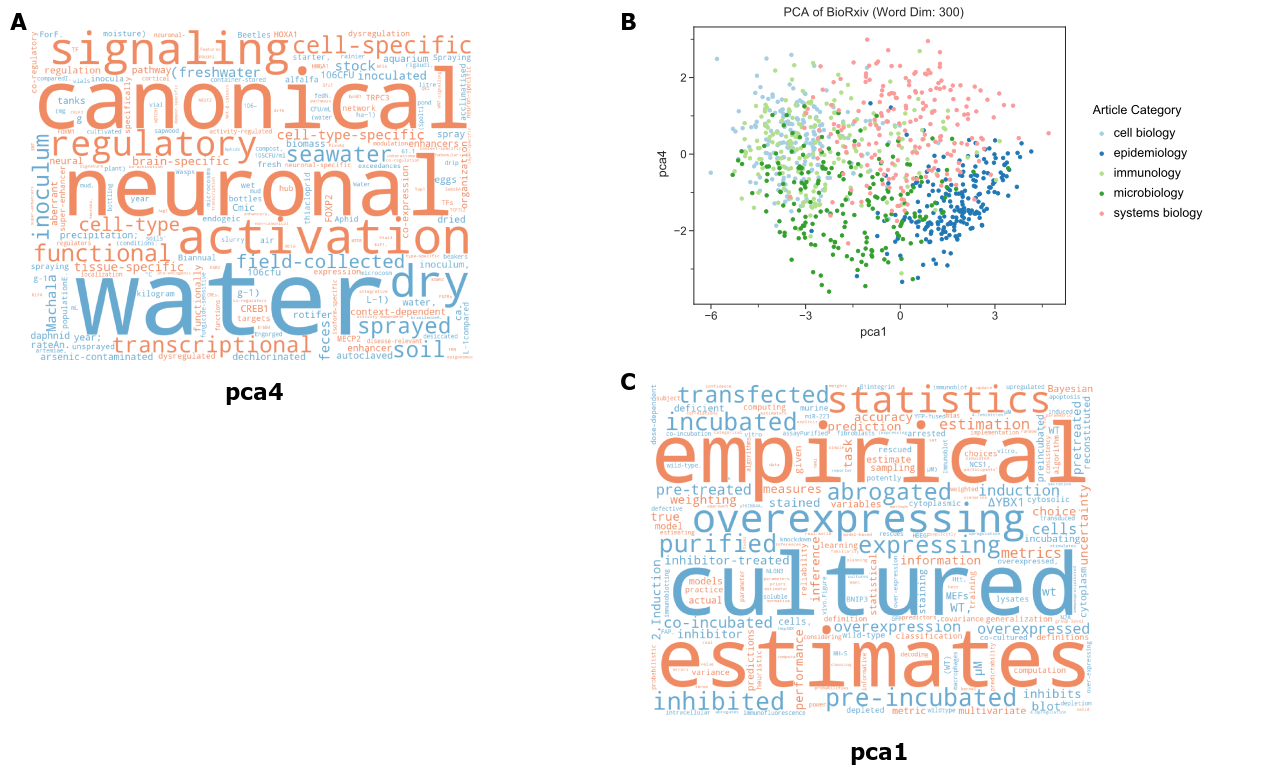

In [34]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca04.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_04_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca01_v_pca04_figure.png",
)

In [35]:
(
    pca_df[["pca1", "pca4", "category", "doi"]]
    .query("pca1 < -2 & pca4 > 0")
    .category.value_counts()
    .head(10)
)

cell biology             2039
developmental biology    1366
neuroscience             1237
cancer biology           1122
molecular biology         978
immunology                757
biochemistry              561
microbiology              478
genetics                  475
plant biology             299
Name: category, dtype: int64

In [36]:
(
    pca_df[["pca1", "pca4", "category", "doi"]]
    .query("pca1 < 0 & pca4 < 0")
    .category.value_counts()
    .head(10)
)

microbiology            4010
biochemistry            1190
biophysics              1133
neuroscience            1104
plant biology           1100
cell biology            1059
molecular biology        766
bioengineering           748
immunology               696
evolutionary biology     614
Name: category, dtype: int64

Looking on the left size of PCA1 (negative), it looks like the top quadrant contains mainly cell biology papers and variants of cell biology. The bottom quadrant contains papers that are related to microbiology; Fun anecdote is that I super convinced that PCA4 was marine biology, but upon closer inspection turns out I was wrong it is microbio.

# Non-straightforward PCs

This section of the notebook aims to take a look at PCs that are not as straightforward as the ones above.

## PCA1 vs PCA6

In [37]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_06_cossim_word_cloud.png",
)

The right word cloud appears to represent mathematics vs scientific communication or at least popular buzz words scientist used to promote their research. The next few cells will look more into it.

In [38]:
selected_categories = [
    "biophysics",
    "bioengineering",
    "clinical trials",
    "scientific communication",
    "synthetic biology",
]

In [39]:
generate_scatter_plots(
    pca_df,
    x="pca1",
    y="pca6",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca06.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca01_v_pca06.svg


<ggplot: (-9223363297868431577)>


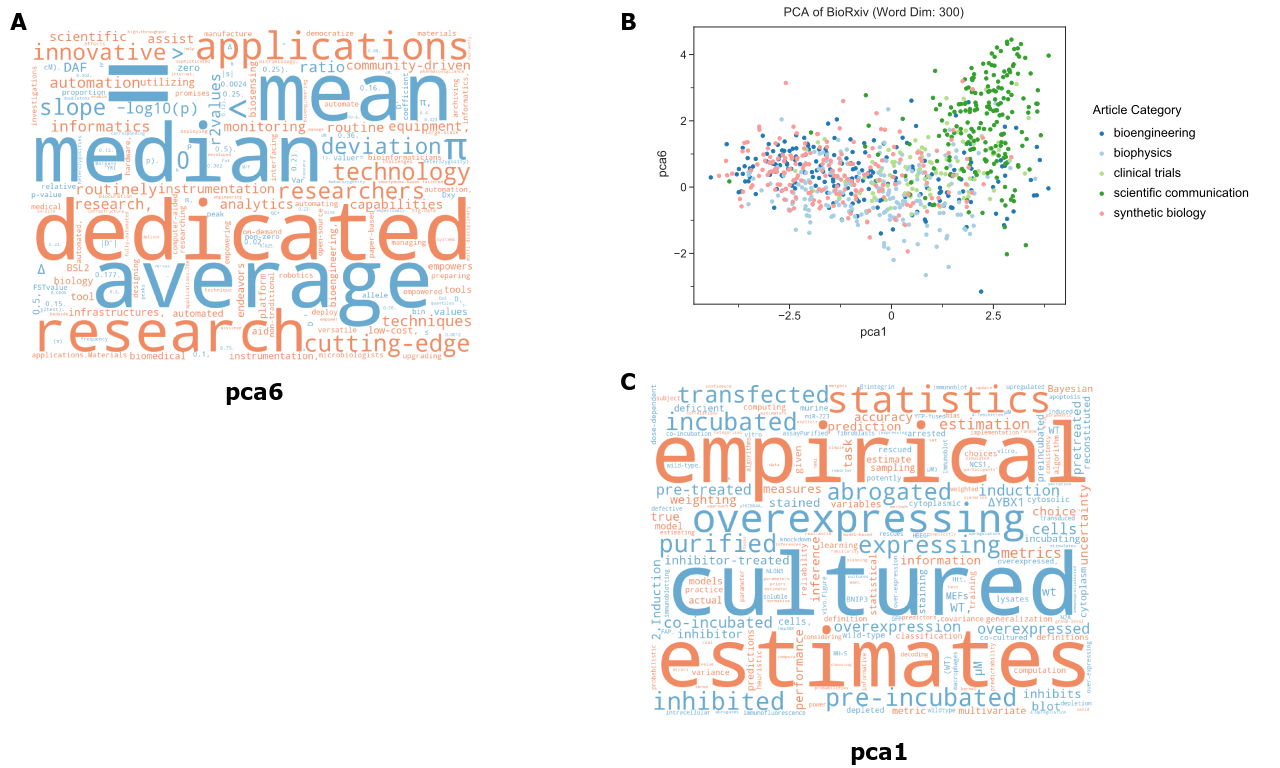

In [40]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca01_v_pca06.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_01_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_06_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca01_v_pca06_figure.png",
)

In [41]:
(
    pca_df[["pca1", "pca6", "category", "doi"]]
    .drop_duplicates("doi")
    .query("pca1 > 0 & pca6 > 3")
    .category.value_counts()
    .head(10)
)

bioinformatics              257
scientific communication    117
neuroscience                 41
ecology                      22
genomics                     20
systems biology              17
epidemiology                 16
bioengineering               15
biophysics                   13
microbiology                 12
Name: category, dtype: int64

In [42]:
(
    pca_df[["pca1", "pca6", "category", "doi"]]
    .drop_duplicates("doi")
    .query("pca1 > 0 & pca6 < -1.5")
    .category.value_counts()
    .head(10)
)

evolutionary biology    821
genetics                504
genomics                318
bioinformatics          261
neuroscience            222
biophysics               92
systems biology          84
ecology                  75
cancer biology           49
epidemiology             38
Name: category, dtype: int64

Looking at the top categories for the top and bottom right quadrants it seems that the papers follow the patterns captures by the word clouds above; however the positive axis still remains difficult to judge without taking a look at the individual papers.

In [43]:
(
    pca_df[["pca1", "pca6", "category", "doi"]]
    .drop_duplicates("doi")
    .query("pca1 > 0 & pca6 > 3")
    .sort_values("pca6", ascending=False)
    .head(10)
)

pca1      pca6                       category             doi
69580  3.199558  6.017543                 bioinformatics  10.1101/610741
61026  3.042379  5.740594                 bioinformatics  10.1101/276485
46386  3.202682  5.573135                 bioinformatics  10.1101/204495
50501  2.143476  5.311097                systems biology  10.1101/038117
26708  3.474341  5.191860                 bioinformatics  10.1101/201186
28298  4.596815  5.181052  animal behavior and cognition  10.1101/377960
32096  3.475192  5.132834       scientific communication  10.1101/122424
1099   2.623749  5.104631       scientific communication  10.1101/518498
13210  0.453545  4.929136                 bioengineering  10.1101/796516
36174  3.716908  4.917438                systems biology  10.1101/109207

## PCA2 vs PCA15

In [44]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_15_cossim_word_cloud.png",
)

The word cloud on the right seems to contain the following concepts: facial recognition and behavior vs neuron biochemistry.

In [45]:
selected_categories = [
    "animal behavior and cognition",
    "biochemistry",
    "cell biology",
    "molecular biology",
    "neuroscience",
]

In [46]:
generate_scatter_plots(
    pca_df,
    x="pca2",
    y="pca15",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca15.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca02_v_pca15.svg


<ggplot: (-9223363297871062233)>


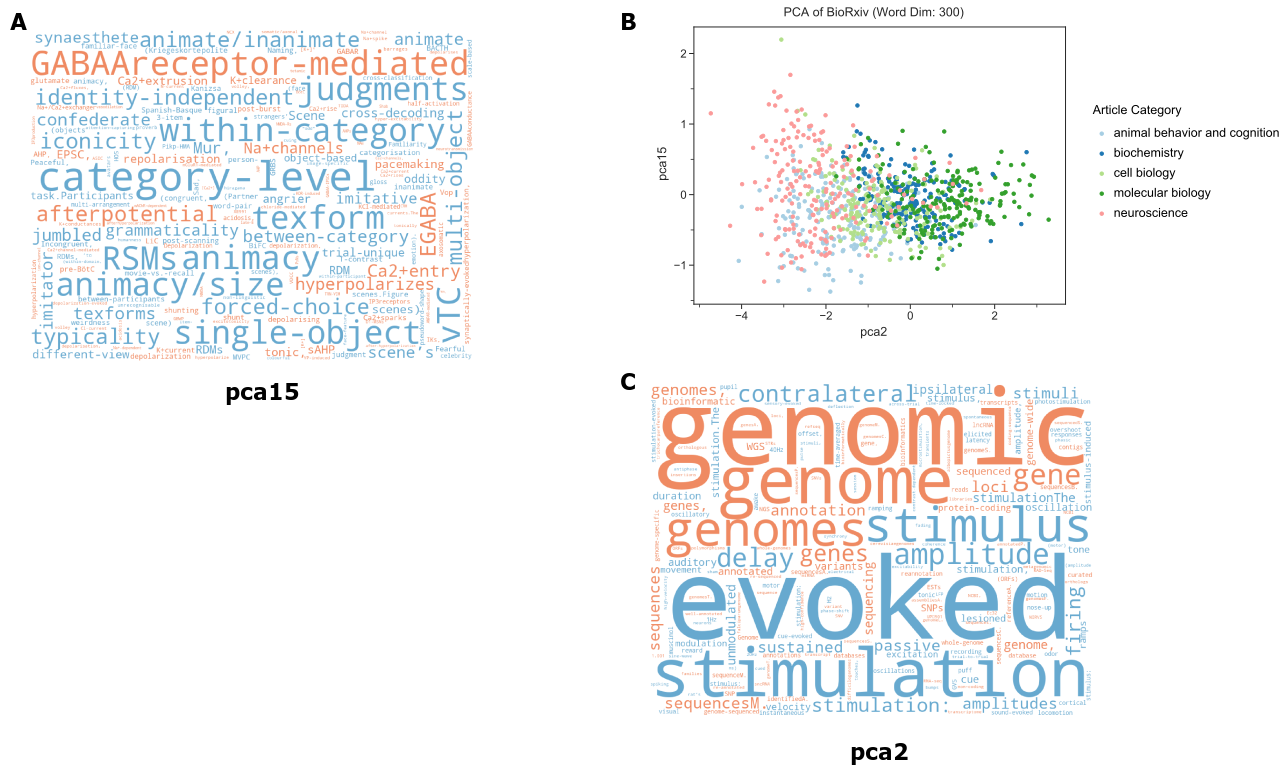

In [47]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca15.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_15_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca02_v_pca15_figure.png",
)

This graph depicts diversity within the neuroscience field as some papers are about facial recognition (negative) and other papers are about biochemistry (positive).

In [48]:
(
    pca_df[["pca2", "pca15", "category", "document", "doi"]]
    .sort_values(["pca15", "pca2"], ascending=[False, False])
    .head(10)
)

pca2     pca15      category       document             doi
60030 -4.666621  2.874970  neuroscience  466300_v1.xml  10.1101/466300
23115 -3.959791  2.323217  neuroscience  053637_v1.xml  10.1101/053637
64844 -4.195080  2.276012  neuroscience  119859_v1.xml  10.1101/119859
21266 -3.595040  2.201443  neuroscience  075697_v1.xml  10.1101/075697
536   -3.057822  2.197123  cell biology  155093_v1.xml  10.1101/155093
44326 -2.741087  2.196218  neuroscience  072041_v1.xml  10.1101/072041
55856 -4.155904  2.195683  neuroscience  361014_v1.xml  10.1101/361014
38894 -4.087525  2.172397  neuroscience  282012_v2.xml  10.1101/282012
45319 -3.586306  2.147911  neuroscience  024653_v1.xml  10.1101/024653
55954 -3.616043  2.147108  neuroscience  566117_v2.xml  10.1101/566117

In [49]:
(
    pca_df[["pca2", "pca15", "category", "document", "doi"]]
    .sort_values(["pca15", "pca2"], ascending=[False, False])
    .tail(10)
)

pca2     pca15                       category       document  \
11101 -2.194532 -1.596621                   neuroscience  186924_v1.xml   
32356 -3.026858 -1.611846  animal behavior and cognition  701995_v1.xml   
46931 -2.383721 -1.616902                   neuroscience  338475_v2.xml   
27633 -3.296298 -1.624607                   neuroscience  740555_v2.xml   
51284 -2.596866 -1.635717                   neuroscience  058537_v3.xml   
3673  -2.190250 -1.638188                   neuroscience  141861_v1.xml   
69651 -2.315590 -1.650163                   neuroscience  194829_v1.xml   
20795 -2.153772 -1.651122                   neuroscience  533513_v2.xml   
12323 -3.051240 -1.764098                   neuroscience  206003_v1.xml   
10527 -2.089817 -1.765300                   neuroscience  293225_v1.xml   

                  doi  
11101  10.1101/186924  
32356  10.1101/701995  
46931  10.1101/338475  
27633  10.1101/740555  
51284  10.1101/058537  
3673   10.1101/141861  
69651  10.1101/194829  
20795  10.1101/533513  
12323  10.1101/206003  
10527  10.1101/293225

These papers confirm that the negative axis of PCA15 is facial recognition.

## PCA2 vs PCA8

In [50]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_08_cossim_word_cloud.png",
)

The wordcloud on the right seems to represent the following concept:  biochemistry vs developmental biology. Main evidence for this appears in the plot below.

In [51]:
selected_categories = [
    "biochemistry",
    "biophysics",
    "cell biology",
    "developmental biology",
    "plant biology",
]

In [52]:
generate_scatter_plots(
    pca_df,
    x="pca2",
    y="pca8",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca08.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca02_v_pca08.svg


<ggplot: (8738983759112)>


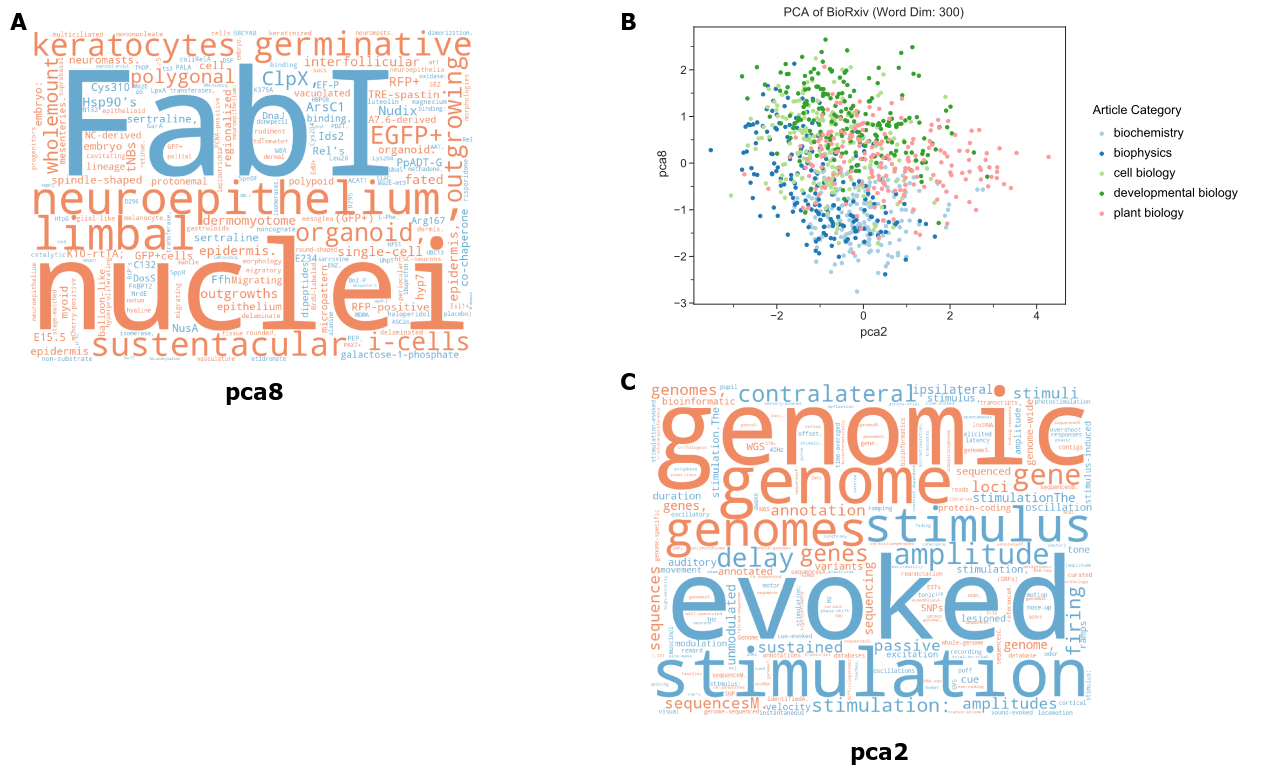

In [53]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca08.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_08_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca02_v_pca08_figure.png",
)

In [54]:
(
    pca_df[["pca2", "pca8", "category", "doi"]]
    .query("pca2 > -2 & pca2 < 2 & pca8 < -1")
    .category.value_counts()
    .head(10)
)

biochemistry         1257
biophysics            795
microbiology          481
molecular biology     434
bioinformatics        353
neuroscience          298
genetics              283
epidemiology          178
cell biology          138
plant biology         120
Name: category, dtype: int64

In [55]:
(
    pca_df[["pca2", "pca8", "category", "doi"]]
    .query("pca2 > -2 & pca2 < 2 & pca8 > 1")
    .category.value_counts()
    .head(10)
)

developmental biology    964
cell biology             660
neuroscience             522
bioinformatics           404
cancer biology           308
evolutionary biology     307
immunology               260
bioengineering           210
genomics                 205
ecology                  201
Name: category, dtype: int64

Looking at the top left and bottom left quadrants the top categories are: biochemistry and developmental biology. Based on this confirmation I'd argue that pca8 covers both of these concepts.

## PCA2 VS PCA13

In [56]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_13_cossim_word_cloud.png",
)

Based on a quick google search the wordcloud on the right represents: viruses (immunology) vs model organisms.

In [57]:
selected_categories = [
    "animal behavior and cognition",
    "developmental biology" "genetics",
    "immunology",
    "microbiology",
]

In [58]:
generate_scatter_plots(
    pca_df,
    x="pca2",
    y="pca13",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca13.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca02_v_pca13.svg


<ggplot: (8738983661846)>


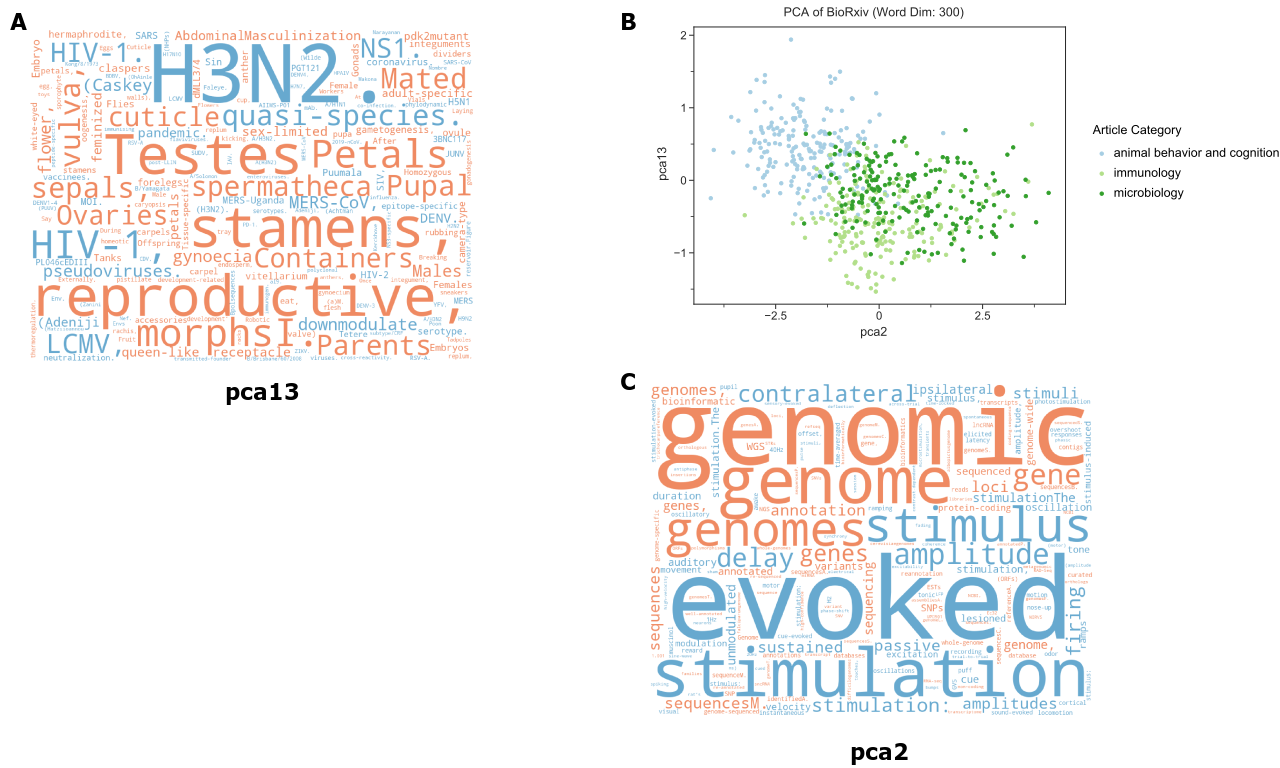

In [59]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca02_v_pca13.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_02_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_13_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca02_v_pca13_figure.png",
)

In [60]:
(
    pca_df[["pca2", "pca13", "category", "doi"]]
    .sort_values("pca13", ascending=False)
    .head(10)
)

pca2     pca13                       category             doi
71014 -0.230158  2.705651                       genetics  10.1101/837526
5721   0.223596  2.132478                     biophysics  10.1101/771725
36808 -1.342941  2.090216          developmental biology  10.1101/180562
67917 -2.129618  1.939689  animal behavior and cognition  10.1101/801993
22127 -0.453975  1.883982                        zoology  10.1101/572149
5235   1.073262  1.822232                   microbiology  10.1101/689646
48412  0.480089  1.792276                 bioengineering  10.1101/592931
39022  2.885687  1.781428                systems biology  10.1101/589036
46339 -0.275879  1.747573           evolutionary biology  10.1101/218834
59372 -3.063470  1.718986                   neuroscience  10.1101/733733

In [61]:
(
    pca_df[["pca2", "pca13", "category", "doi"]]
    .sort_values("pca13", ascending=True)
    .head(10)
)

pca2     pca13      category             doi
24614  2.194220 -2.473027      genomics  10.1101/521666
28531  0.561802 -2.087082    immunology  10.1101/459164
15608  3.230793 -2.054000    immunology  10.1101/457069
57194 -0.804293 -1.957388    immunology  10.1101/686170
64499  0.444289 -1.949410    immunology  10.1101/823328
25498  1.065835 -1.939880  microbiology  10.1101/817320
36154  0.209931 -1.880022    immunology  10.1101/565259
38206  0.855564 -1.870947  microbiology  10.1101/790642
44010 -0.150021 -1.855690    immunology  10.1101/537050
4017   0.512949 -1.846959    immunology  10.1101/743187

Looking at the extremes values along PCA13, the categories seem to confirm my suspicions.

## PCA04 vs PCA20

In [62]:
display_clouds(
    "output/word_pca_similarity/figure_pieces/pca_04_cossim_word_cloud.png",
    "output/word_pca_similarity/figure_pieces/pca_20_cossim_word_cloud.png",
)

PCA20 represents the following concepts: immunology and cancer biology.

In [63]:
selected_categories = [
    "cancer biology",
    "immunology",
    "molecular biology",
    "microbiology",
    "neuroscience",
]

In [64]:
generate_scatter_plots(
    pca_df,
    x="pca4",
    y="pca20",
    nsample=200,
    random_state=100,
    selected_categories=selected_categories,
    color_palette=global_color_palette,
    save_file_path="output/pca_plots/svg_files/scatterplot_files/pca04_v_pca20.svg",
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/scatterplot_files/pca04_v_pca20.svg


<ggplot: (8738983678819)>


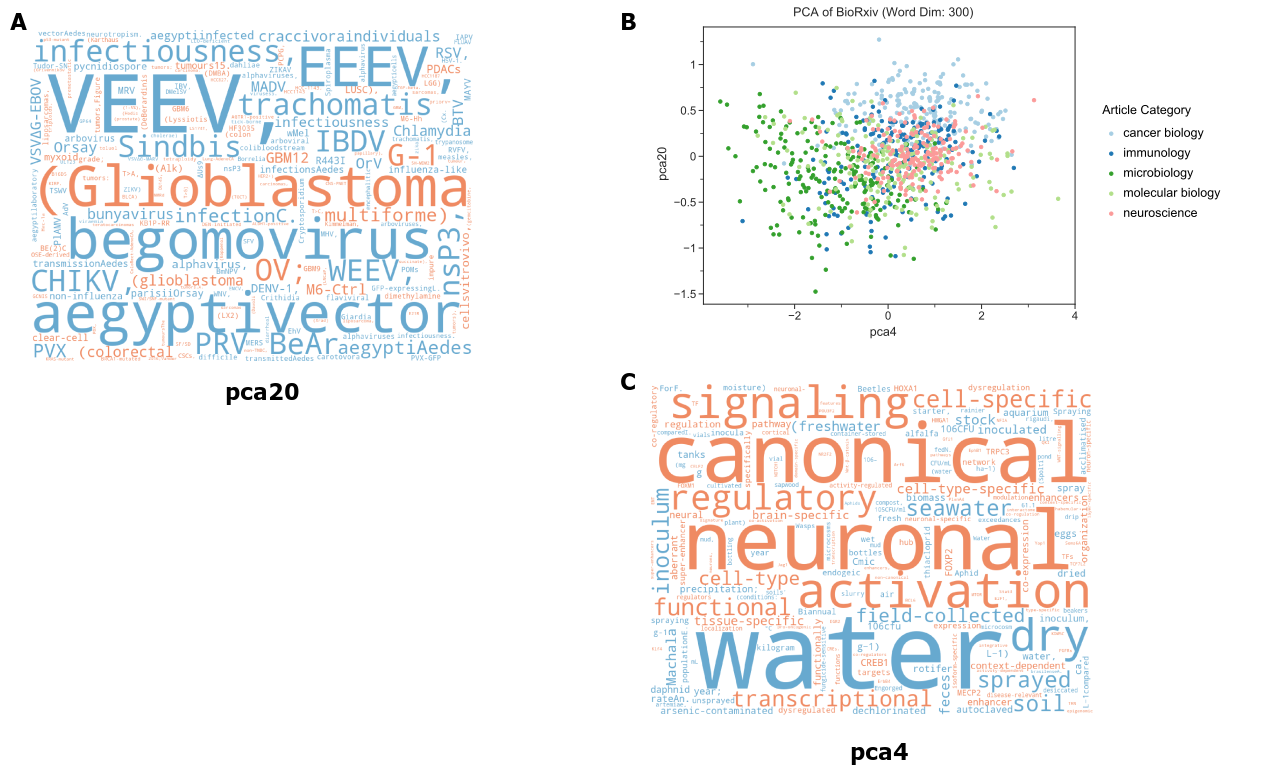

In [65]:
plot_scatter_clouds(
    scatter_plot_path="output/pca_plots/svg_files/scatterplot_files/pca04_v_pca20.svg",
    word_cloud_x_path="output/word_pca_similarity/figure_pieces/pca_04_cossim_word_cloud.png",
    word_cloud_y_path="output/word_pca_similarity/figure_pieces/pca_20_cossim_word_cloud.png",
    final_figure_path="output/pca_plots/figures/pca04_v_pca20_figure.png",
)

In [66]:
(
    pca_df[["pca4", "pca20", "category", "doi"]]
    .query("pca4 < 0 & pca20 < 0")
    .category.value_counts()
    .head(10)
)

microbiology            3668
epidemiology            1353
ecology                 1131
neuroscience            1106
biophysics               950
genetics                 869
evolutionary biology     862
bioinformatics           763
plant biology            745
genomics                 683
Name: category, dtype: int64

In [67]:
(
    pca_df[["pca4", "pca20", "category", "doi"]]
    .query("pca4 > 0 & pca20 > 0")
    .category.value_counts()
    .head(10)
)

neuroscience             4608
bioinformatics           2672
cancer biology           1807
genomics                 1312
cell biology             1034
developmental biology     804
immunology                701
genetics                  684
evolutionary biology      652
biophysics                633
Name: category, dtype: int64